# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report



import mok_py as t

#import plotly.express as px

#from plotly import graph_objs as go
#from plotly import graph_objects as go

#import plotly.plotly


%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data set analysis

## Portfolio

In [2]:
portfolio.shape

(10, 6)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [5]:
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [6]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [7]:
portfolio.dtypes


channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

## Profile

In [8]:
profile.shape

(17000, 5)

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
profile.groupby(['gender']).size().reset_index(name='counts')

,gender,counts
0,F,6129
1,M,8484
2,O,212


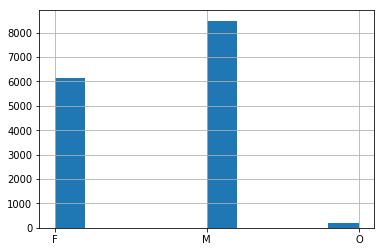

In [12]:
profile.gender.hist()

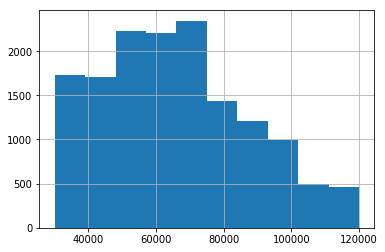

In [13]:
profile.income.hist()

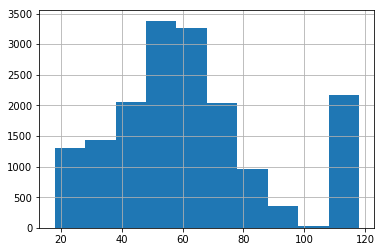

In [14]:
profile.age.hist()

In [15]:
#looks like it was input by mistake as gender and income are missing, will drop it in the cleaning part
profile.loc[profile['age'] == 118].isnull().sum()


age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [16]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [17]:
profile.dtypes


age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

## Transcript

In [18]:
transcript.shape

(306534, 4)

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [21]:
transcript.groupby(['event']).size().reset_index(name='counts')

,event,counts
0,offer completed,33579
1,offer received,76277
2,offer viewed,57725
3,transaction,138953


In [22]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [23]:
profile.dtypes


age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

## Clean Portfolio

In [24]:
dfPortfolio = portfolio.copy()
dummy = pd.get_dummies(dfPortfolio.channels.apply(pd.Series).stack()).sum(level=0)
dfPortfolio = pd.concat([dfPortfolio, dummy], axis=1)
#dfPortfolio = dfPortfolio.drop(columns='channels')

dummy = pd.get_dummies(dfPortfolio.offer_type.apply(pd.Series).stack()).sum(level=0)
dfPortfolio = pd.concat([dfPortfolio, dummy], axis=1)
#dfPortfolio = dfPortfolio.drop(columns='offer_type')


dfPortfolio['chnl_count'] = dfPortfolio['mobile'] + dfPortfolio['email'] + dfPortfolio['social'] + dfPortfolio['web']


dfPortfolio['duration'] = dfPortfolio['duration'].apply(lambda x: x*24)
dfPortfolio

dfPortfolio.rename(columns={'id':'offer_id'}, inplace=True)


## Clean Profile

In [25]:
bins = [18, 30, 40, 50, 60, 70, 120]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']

profile['agerange'] = pd.cut(profile.age, bins, labels = labels, include_lowest = True)
profile.dropna(inplace=True)

dfProfile = profile.copy()
dummy = pd.get_dummies(dfProfile.gender.apply(pd.Series).stack()).sum(level=0)
dfProfile = pd.concat([dfProfile, dummy], axis=1)
#dfProfile = dfProfile.drop(columns='gender')
dfProfile.rename(columns={'id':'person'}, inplace=True)




dfProfile.head()

,age,became_member_on,gender,person,income,agerange,F,M,O
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,50-59,1,0,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,70+,1,0,0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,60-69,0,1,0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,60-69,0,1,0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,50-59,0,1,0


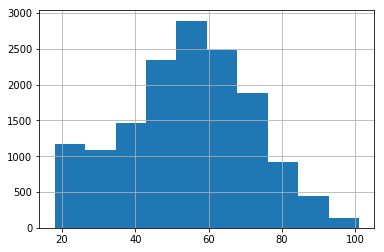

In [26]:
dfProfile.age.hist()

In [27]:
profile.groupby(['agerange']).size().reset_index(name='counts')

,agerange,counts
0,18-29,1705
1,30-39,1597
2,40-49,2391
3,50-59,3590
4,60-69,2910
5,70+,2632


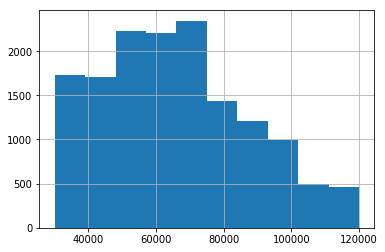

In [28]:
profile.income.hist()

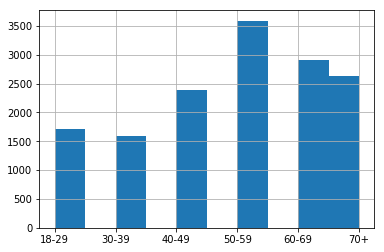

In [29]:
dfProfile.agerange.hist()


## Clean Transcript

In [30]:
#split value into columns (amount , offer if,...)
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.drop(columns=['value'], inplace=True)
transcript.head()

,event,person,time,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [31]:
#Split event into columns with value 1 if applicable 
dfEvents = transcript.copy()
dummy = pd.get_dummies(dfEvents.event.apply(pd.Series).stack()).sum(level=0)
dfEvents = pd.concat([dfEvents, dummy], axis=1)
dfEvents = dfEvents.drop(columns='event')

dfEvents = dfEvents[['person','offer id','time', 'amount', 'offer_id', 'reward','offer received','offer viewed','offer completed','transaction']]


dfEvents.head()

,person,offer id,time,amount,offer_id,reward,offer received,offer viewed,offer completed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,NaN,NaN,NaN,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN,NaN,NaN,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,NaN,NaN,NaN,1,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,NaN,NaN,NaN,1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,NaN,NaN,NaN,1,0,0,0


In [32]:
#Since offer_id column seems redundent when event = offer completed, we need to have this value in the right place
dfEvents['offer id'] = dfEvents.apply(lambda x: x['offer_id'] if x['offer completed']==1 else x['offer id'], axis=1)

dfEvents.drop(columns=['offer_id'], inplace=True)
dfEvents.sort_values(['person', 'offer id', 'time'], ascending=[True, True, True], inplace=True)

dfEvents.head()



,person,offer id,time,amount,reward,offer received,offer viewed,offer completed,transaction
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,NaN,1,0,0,0
258884,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,2.0,0,0,1,0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,NaN,NaN,1,0,0,0
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,NaN,NaN,0,1,0,0
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,NaN,NaN,1,0,0,0


In [33]:
#There are two types of completion, one where the offer was used and one where the user did not care about the 
# and rather is a heavy spender, we need to keep track of this
def analyzeCompletion(df):
    '''
    inputs:
    - df: dataframe to analyze for offer completion
    outputs:
    - Returns dataframe with an additional column that describe the completion 
    
    '''
    
    df['W/ Promotion'] = 0 
    viewed = ''
    lastOffer = ''
    
    for index, row in df.iterrows():
        
        if lastOffer != row['offer id']:
            viewed = ''

        if row['offer completed'] == 1:
            if viewed == 'X':
                df.loc[index, 'W/ Promotion'] = 1
#            else:
#                df.loc[index, 'Promotion'] = 'Not'

        
        if row['offer viewed'] == 1:
            viewed = 'X'

        lastOffer = row['offer id']
    
    return df

#vaue to be referenced 
#toBe = dfEvents.loc[dfEvents['person'] == '0020c2b971eb4e9188eac86d93036a77']
dfEvents = analyzeCompletion(dfEvents)
#dfEvents.loc[dfEvents['person'] == '0020c2b971eb4e9188eac86d93036a77']



In [34]:
dfEvents.rename(columns={'offer id':'offer_id'}, inplace=True)
dfWithOffer = pd.merge(dfEvents, dfPortfolio, how='inner', on=['offer_id'])
dfFull = pd.merge(dfWithOffer, dfProfile, how='inner', on=['person'])

dfFull.sort_values(['person', 'offer_id', 'offer completed'], ascending=[True, True, False], inplace=True)
dfFull.drop_duplicates(subset=['person', 'offer_id'], keep='first', inplace=True)

dfFull.head()

,person,offer_id,time,amount,reward_x,offer received,offer viewed,offer completed,transaction,W/ Promotion,...,informational,chnl_count,age,became_member_on,gender,income,agerange,F,M,O
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,2.0,0,0,1,0,0,...,0,3,33,20170421,M,72000.0,30-39,0,1,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,NaN,NaN,1,0,0,0,0,...,1,3,33,20170421,M,72000.0,30-39,0,1,0
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,NaN,NaN,1,0,0,0,0,...,1,3,33,20170421,M,72000.0,30-39,0,1,0
7,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414,NaN,5.0,0,0,1,0,0,...,0,4,33,20170421,M,72000.0,30-39,0,1,0
10,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528,NaN,2.0,0,0,1,0,0,...,0,4,33,20170421,M,72000.0,30-39,0,1,0


In [35]:
dfFull.columns

Index(['person', 'offer_id', 'time', 'amount', 'reward_x', 'offer received',
       'offer viewed', 'offer completed', 'transaction', 'W/ Promotion',
       'channels', 'difficulty', 'duration', 'offer_type', 'reward_y', 'email',
       'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       'chnl_count', 'age', 'became_member_on', 'gender', 'income', 'agerange',
       'F', 'M', 'O'],
      dtype='object')

In [36]:
dfFull.head()

,person,offer_id,time,amount,reward_x,offer received,offer viewed,offer completed,transaction,W/ Promotion,...,informational,chnl_count,age,became_member_on,gender,income,agerange,F,M,O
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,2.0,0,0,1,0,0,...,0,3,33,20170421,M,72000.0,30-39,0,1,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,NaN,NaN,1,0,0,0,0,...,1,3,33,20170421,M,72000.0,30-39,0,1,0
4,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,NaN,NaN,1,0,0,0,0,...,1,3,33,20170421,M,72000.0,30-39,0,1,0
7,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414,NaN,5.0,0,0,1,0,0,...,0,4,33,20170421,M,72000.0,30-39,0,1,0
10,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528,NaN,2.0,0,0,1,0,0,...,0,4,33,20170421,M,72000.0,30-39,0,1,0


# Visualization

In [37]:
groupByGender = dfFull.groupby(['gender', 'offer completed','W/ Promotion']).agg({'person': 'count'})

groupByGenderPct = groupByGender.groupby(level=0).apply(lambda x: 100*x / float(x.sum())).reset_index()

groupByGenderPct

,gender,offer completed,W/ Promotion,person
0,F,0,0,41.866889
1,F,1,0,17.879691
2,F,1,1,40.253420
3,M,0,0,54.956549
4,M,1,0,12.469584
5,M,1,1,32.573866
6,O,0,0,44.213264
7,O,1,0,10.663199
8,O,1,1,45.123537


In [38]:
#groupByGenderPct.T.plot.pie(subplots=True, figsize=(10,3))

In [39]:
groupByAge = dfFull.groupby(['agerange','offer completed','W/ Promotion']).agg({'person': 'count'})

groupByAgePct = groupByAge.groupby(level=0).apply(lambda x: 100*x / float(x.sum())).reset_index()

groupByAgePct

,agerange,offer completed,W/ Promotion,person
0,18-29,0,0,60.068793
1,18-29,1,0,12.867417
2,18-29,1,1,27.063790
3,30-39,0,0,53.640615
4,30-39,1,0,12.825651
5,30-39,1,1,33.533734
6,40-49,0,0,50.351554
7,40-49,1,0,12.020866
8,40-49,1,1,37.627580
9,50-59,0,0,46.449792


In [40]:
groupByDiff = dfFull.groupby(['difficulty','offer completed','W/ Promotion']).agg({'person': 'count'})

groupByDiffPct = groupByDiff.groupby(level=0).apply(lambda x: 100*x / float(x.sum())).reset_index()

groupByDiffPct

,difficulty,offer completed,W/ Promotion,person
0,0,0,0,100.000000
1,5,0,0,34.568126
2,5,1,0,21.716574
3,5,1,1,43.715300
4,7,0,0,24.332668
5,7,1,0,10.749955
6,7,1,1,64.917378
7,10,0,0,38.268700
8,10,1,0,15.258609
9,10,1,1,46.472691


In [41]:
groupByChCount = dfFull.groupby(['chnl_count','offer completed','W/ Promotion']).agg({'person': 'count'})

groupByChCountPct = groupByChCount.groupby(level=0).apply(lambda x: 100*x / float(x.sum())).reset_index()

groupByChCountPct

,chnl_count,offer completed,W/ Promotion,person
0,2,0,0,47.315676
1,2,1,0,31.424481
2,2,1,1,21.259843
3,3,0,0,63.238861
4,3,1,0,15.300250
5,3,1,1,21.460890
6,4,0,0,32.557823
7,4,1,0,9.646931
8,4,1,1,57.795247


In [42]:
groupByMobile = dfFull.groupby(['mobile','offer completed','W/ Promotion']).agg({'person': 'count'})

groupByMobilePct = groupByMobile.groupby(level=0).apply(lambda x: 100*x / float(x.sum())).reset_index()

groupByMobilePct

,mobile,offer completed,W/ Promotion,person
0,0,0,0,47.315676
1,0,1,0,31.424481
2,0,1,1,21.259843
3,1,0,0,49.635331
4,1,1,0,12.793650
5,1,1,1,37.571020


In [43]:
groupBySocial = dfFull.groupby(['social','offer completed','W/ Promotion']).agg({'person': 'count'})

groupBySocialPct = groupBySocial.groupby(level=0).apply(lambda x: 100*x / float(x.sum())).reset_index()

groupBySocialPct

,social,offer completed,W/ Promotion,person
0,0,0,0,55.028463
1,0,1,0,23.140869
2,0,1,1,21.830668
3,1,0,0,45.635880
4,1,1,0,9.018375
5,1,1,1,45.345745


In [44]:
groupByWeb = dfFull.groupby(['web','offer completed','W/ Promotion']).agg({'person': 'count'})

groupByWebPct = groupByWeb.groupby(level=0).apply(lambda x: 100*x / float(x.sum())).reset_index()

groupByWebPct

,web,offer completed,W/ Promotion,person
0,0,0,0,71.609061
1,0,1,0,7.770057
2,0,1,1,20.620883
3,1,0,0,43.825468
4,1,1,0,16.413312
5,1,1,1,39.761220


In [45]:
groupByEmail = dfFull.groupby(['email','offer completed','W/ Promotion']).agg({'person': 'count'})

groupByEmailPct = groupByEmail.groupby(level=0).apply(lambda x: 100*x / float(x.sum())).reset_index()

groupByEmailPct

,email,offer completed,W/ Promotion,person
0,1,0,0,49.400601
1,1,1,0,14.678932
2,1,1,1,35.920466


In [46]:
completeNoOffer = np.where((dfFull['offer completed'] == 1) & (dfFull['W/ Promotion'] == 0))
completeNoOffer

(array([    0,     3,     4, ..., 55209, 55216, 55220]),)

In [47]:
dfFull.iloc[completeNoOffer].shape

(8106, 31)

In [48]:
dfFull.iloc[completeNoOffer].sum()

person              0009655768c64bdeb2e877511632db8f0009655768c64b...
offer_id            2906b810c7d4411798c6938adc9daaa5f19421c1d4aa40...
time                                                          3250038
amount                                                              0
reward_x                                                        39710
offer received                                                      0
offer viewed                                                        0
offer completed                                                  8106
transaction                                                         0
W/ Promotion                                                        0
channels            [web, email, mobile, web, email, mobile, socia...
difficulty                                                      84914
duration                                                      1473672
offer_type          discountbogodiscountdiscountbogobogodiscountdi...
reward_y            

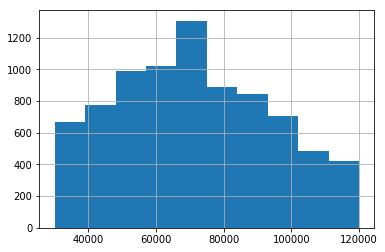

In [49]:
dfFull.iloc[completeNoOffer].income.hist()

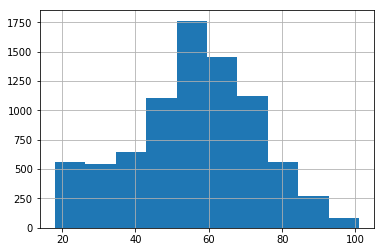

In [50]:
dfFull.iloc[completeNoOffer].age.hist()

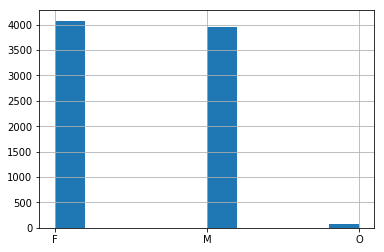

In [51]:
dfFull.iloc[completeNoOffer].gender.hist()

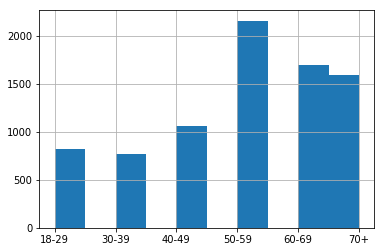

In [52]:
dfFull.iloc[completeNoOffer].agerange.hist()